In [29]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import os

In [30]:
df_test = pd.read_csv('test.csv')
df = pd.read_csv('train.csv')

df = df.drop(columns=["Region_Code", "Driving_License", "Gender"])
df_test = df_test.drop(columns=['Region_Code',"Driving_License", "Gender"])



df.head()

,id,Age,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,21,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,43,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,25,1,< 1 Year,No,38043.0,152.0,254,0
3,3,35,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,36,1,1-2 Year,No,31951.0,152.0,294,0


In [31]:
df['Vehicle_Damage'] = df.Vehicle_Damage.map(dict(Yes=1,No=0))
df_test['Vehicle_Damage'] = df_test.Vehicle_Damage.map(dict(Yes=1,No=0))
df.head()

,id,Age,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,21,0,1-2 Year,1,65101.0,124.0,187,0
1,1,43,0,> 2 Years,1,58911.0,26.0,288,1
2,2,25,1,< 1 Year,0,38043.0,152.0,254,0
3,3,35,0,1-2 Year,1,2630.0,156.0,76,0
4,4,36,1,1-2 Year,0,31951.0,152.0,294,0


In [32]:
df['Vehicle_Age'] = df['Vehicle_Age'].astype('category')
df = pd.get_dummies(df, columns=['Vehicle_Age'])

df_test['Vehicle_Age'] = df_test['Vehicle_Age'].astype('category')
df_test = pd.get_dummies(df_test, columns=['Vehicle_Age'])

df_test.head()

,id,Age,Previously_Insured,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Vehicle_Age_1-2 Year,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years
0,11504798,20,0,0,2630.0,160.0,228,0,1,0
1,11504799,47,0,1,37483.0,124.0,123,1,0,0
2,11504800,47,0,1,2630.0,26.0,271,1,0,0
3,11504801,22,1,0,24502.0,152.0,115,0,1,0
4,11504802,51,0,0,34115.0,124.0,148,1,0,0


In [34]:
# Initializing split data
X_train = df[['Age', 'Previously_Insured', 'Annual_Premium', 
              'Policy_Sales_Channel', 'Vintage', 'Vehicle_Damage', 'Vehicle_Age_1-2 Year','Vehicle_Age_< 1 Year', 
              'Vehicle_Age_> 2 Years',]]
y_train = df['Response']

X_test = df_test[['Age', 'Previously_Insured', 'Annual_Premium', 
                  'Policy_Sales_Channel', 'Vintage', 'Vehicle_Damage', 'Vehicle_Age_1-2 Year','Vehicle_Age_< 1 Year', 
                  'Vehicle_Age_> 2 Years']]

In [7]:
!pip install imblearn

In [35]:
# Using SMOTE to handle impbalanced data
import imblearn
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(y_train.value_counts())
print()
print(y_train_smote.value_counts())

0    10089739
1     1415059
Name: Response, dtype: int64

0    10089739
1    10089739
Name: Response, dtype: int64


In [36]:
# Scaling data
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()

In [37]:
X_train_scaled = scaler.fit_transform(X_train_smote)
data_scaled = scaler.fit_transform(df)

In [38]:
# Splitting training data further down
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_train_scaled, y_train_smote, test_size=0.3,
                                                   random_state=0)

In [39]:
from sklearn import metrics
from sklearn.metrics import *
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from matplotlib.pyplot import subplots
from sklearn.metrics import RocCurveDisplay

In [40]:
# Choosing predictors based off logistic regression

logit = LogisticRegression(C=1e10, solver='liblinear')
logit.fit(x_train, y_train)
logit_pred = logit.predict_proba(x_test)
logit_labels = np.where(logit_pred[:,1]>0.5, 1, 0)
confusion_matrix(logit_labels, y_test)

array([[2024884,  302528],
       [1001266, 2725166]])

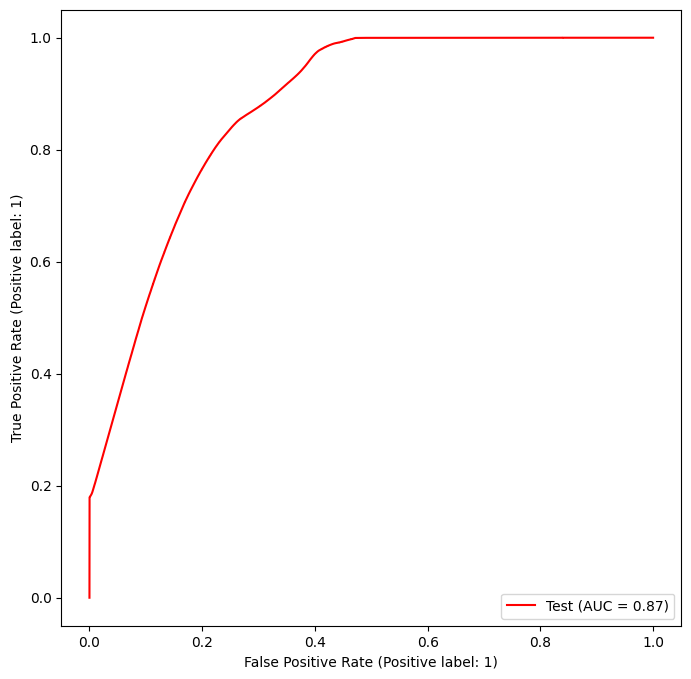

In [41]:
# Plotting ROC curve
roc_curve = RocCurveDisplay.from_estimator

fig, ax = subplots(figsize=(8,8))
roc_curve(logit, # Fitted model
          x_test, # Model matrix
          y_test, # labels
          name='Test',
          color='r',
          ax=ax);

In [42]:
# Using QDA
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA)
from ISLP import confusion_table

lda = LDA(store_covariance = True)
lda.fit(x_train, y_train)

qda = QDA(store_covariance = True)
qda.fit(x_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis(store_covariance=True)

In [43]:
# Making predictions
lda_pred = lda.predict(x_test)
confusion_table(lda_pred, y_test)


Truth,0,1
Predicted,,
0,1828568,96973
1,1197582,2930721


In [44]:
qda_pred = qda.predict(x_test)
confusion_table(qda_pred, y_test)

Truth,0,1
Predicted,,
0,3026094,2484365
1,56,543329


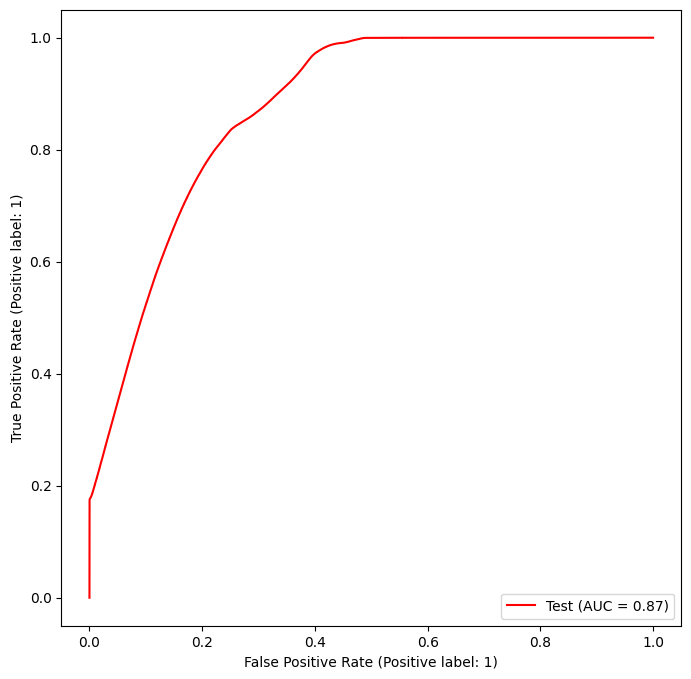

In [45]:
# Plotting ROC curve
fig, ax = subplots(figsize=(8,8))
roc_curve(lda, # Fitted model
          x_test, # Model matrix
          y_test, # labels
          name='Test',
          color='r',
          ax=ax);

# LDA

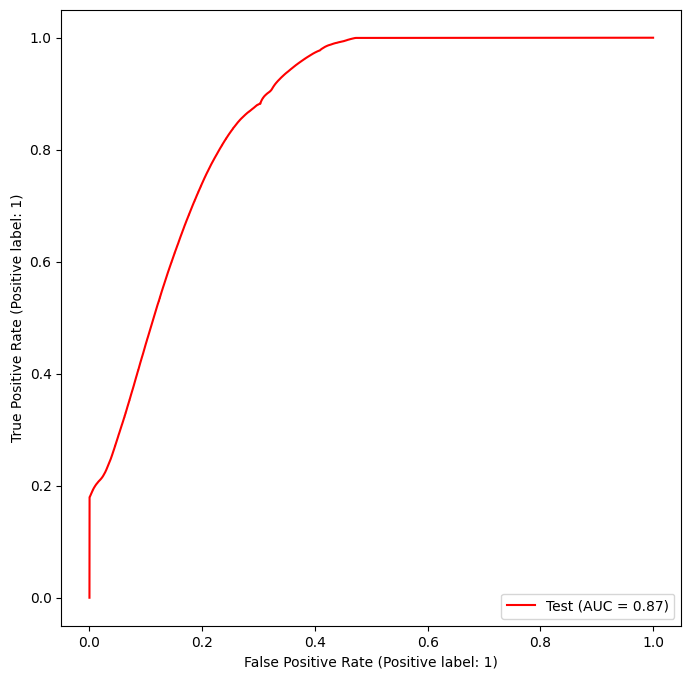

In [46]:
# Plotting ROC curve
fig, ax = subplots(figsize=(8,8))
roc_curve(qda, # Fitted model
          x_test, # Model matrix
          y_test, # labels
          name='Test',
          color='r',
          ax=ax);

# QDA

In [47]:
# Using Random Forests
from sklearn.ensemble import (RandomForestClassifier as RF, GradientBoostingClassifier as GBR)



In [49]:
df.shape

(11504798, 11)

In [51]:
RF_df = RF(n_jobs=-1,
           max_features = 4, # Using sqrt(11) features
          random_state=0).fit(x_train, y_train)
y_hat_RF = RF_df.predict(x_test)

In [57]:
# Viewing the importance of each variable
feature_names = ['Age', 'Previously_Insured', 'Annual_Premium', 
              'Policy_Sales_Channel', 'Vintage', 'Vehicle_Damage', 'Vehicle_Age_1-2 Year','Vehicle_Age_< 1 Year', 
              'Vehicle_Age_> 2 Years']

feature_imp = pd.DataFrame(
    {'importance': RF_df.feature_importances_},
    index=feature_names
)
feature_imp.sort_values(by = 'importance', ascending=False)
# We see all except driving_license, vehicle age, gender_male have over 0.05 impact

,importance
Annual_Premium,0.287815
Previously_Insured,0.258887
Vehicle_Damage,0.124156
Vintage,0.111918
Policy_Sales_Channel,0.076068
Age,0.066841
Vehicle_Age_< 1 Year,0.040244
Vehicle_Age_1-2 Year,0.020326
Vehicle_Age_> 2 Years,0.013745


In [53]:
# Predicting on the actual submission test set
X_test_scaled = scaler.fit_transform(X_test)
y_hat = RF_df.predict_proba(X_test_scaled)
y_hat = [item[1] for item in y_hat]

In [54]:
# Write to submission file
np.savetxt(
    'submission.csv',
    np.rec.fromarrays([df_test['id'],y_hat]),
    fmt=['%d','%f'],
    delimiter=',',
    header='id,response',
    comments=''
)
!head submission.csv

id,response
11504798,0.690000
11504799,0.630000
11504800,0.685000
11504801,0.000000
11504802,0.130000
11504803,0.000000
11504804,0.459024
11504805,0.050000
11504806,0.000000


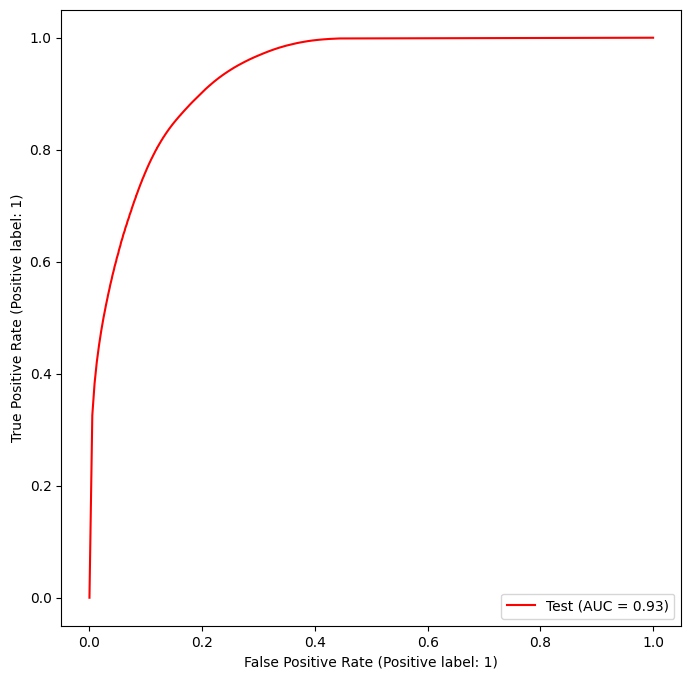

In [55]:
# Plotting ROC curve
roc_curve = RocCurveDisplay.from_estimator

fig, ax = subplots(figsize=(8,8))
roc_curve(RF_df, # Fitted model
          x_test, # Model matrix
          y_test, # labels
          name='Test',
          color='r',
          ax=ax);
# Notice Random Forest had the best AUC!!

In [56]:
submission = pd.read_csv('submission.csv')
submission.shape

(7669866, 2)